In [143]:
import pandas as pd
import tools.config as config
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import math
from tools.tools import get_path

import tools.config as config
sns.set(style="darkgrid")

In [225]:
from scipy.ndimage import gaussian_filter1d

def find_inflection_point(x, y, sigma=2, x_threshold=None):
    """
    使用二阶导数最小值法寻找拐点，并允许设置x阈值，忽略较小的x部分。

    参数:
    - x, y: 输入数组
    - sigma: 高斯平滑参数
    - x_threshold: 若设置，仅考虑 x > x_threshold 的部分

    返回:
    - 拐点坐标 (x, y)
    """
    # 平滑处理
    y_smooth = gaussian_filter1d(y, sigma=sigma)
    
    # 计算导数
    dy = np.gradient(y_smooth, x)
    ddy = np.gradient(dy, x)

    # 可选：只保留 x > x_threshold 的数据
    if x_threshold is not None:
        mask = x >= (x_threshold - x_threshold* 0.05)  # 允许一定的误差
        if not np.any(mask):
            raise ValueError("No x values satisfy x > x_threshold")
        x = x[mask]
        y_smooth = y_smooth[mask]
        ddy = ddy[mask]

    # 找二阶导数最小的位置
    inflection_idx = np.argmin(ddy)
    inflection_idx = max(1, min(inflection_idx, len(x)-2))  # 保证索引合法

    return x[inflection_idx], y_smooth[inflection_idx]

In [237]:
def process_cuve_data(year,arr_x='carbon_price',arr_y='ghg', gap=1):
    price_arr = np.load(f"{config.TASK_DIR}/carbon_price/data/{arr_x}_{year}.npy")
    ghg_arr = np.load(f"{config.TASK_DIR}/carbon_price/data/{arr_y}_{year}.npy")
    
    df = pd.DataFrame({
        'price': price_arr.flatten(),
        'ghg': ghg_arr.flatten(),
    })
    df_sorted = df.sort_values(by='price', ascending=True).reset_index(drop=True)
    df_sorted['cumulative_ghg'] = df_sorted['ghg'].cumsum() / 1e6

    df_sorted = df_sorted[df_sorted['ghg'] > 1].reset_index(drop=True)
    df_sorted = df_sorted[df_sorted['price'] > 1].reset_index(drop=True)
    df_sorted = df_sorted.drop_duplicates(subset='price')

    x = df_sorted['price'].values
    y = df_sorted['cumulative_ghg'].values

    mask = x < np.percentile(x[~np.isnan(x)], 99)
    x_filtered = x[mask]
    y_filtered = y[mask]

    target_y = np.max(y_filtered) - gap

    # 找到最接近 target_y 的点
    closest_idx = np.argmin(np.abs(y_filtered - target_y))
    adjusted_x = x_filtered[closest_idx]
    adjusted_y = y_filtered[closest_idx]
    return x_filtered, y_filtered, (adjusted_x, adjusted_y)
    

In [238]:
def batch_plot_efficiency(plot_data_dict, y_label, per_col=6):
    """
    把 plot_data_dict（以年份为 key）画成“每行 per_col 张”的网格。
    
    参数:
    - plot_data_dict: dict，每个 key 是年份，每个 value 是 dict，包含 'x','y','point'
    - per_col: 每行的子图数目，默认 6
    """
    years = sorted(plot_data_dict.keys())
    count = len(years)
    ncols = per_col
    nrows = math.ceil(count / per_col)
    
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(ncols * 4, nrows * 3),
        squeeze=False
    )
    
    for idx, year in enumerate(years):
        row = idx // per_col  # 修改顺序：先行后列
        col = idx % per_col
        ax = axes[row][col]

        data = plot_data_dict[year]
        x, y = data['x'], data['y']
        pt_x, pt_y = data['point']

        sns.lineplot(x=x, y=y, ax=ax)
        ax.scatter(
            pt_x, pt_y,
            color='red', s=40, zorder=10,
            label="Selected Carbon Price" if idx == count - 1 else None
        )
        ax.text(
            pt_x, pt_y,
            f"({pt_x:.2f}, {pt_y:.2f})",
            fontsize=8,
            ha='left', va='bottom', color='red'
        )

        ax.set_title(f"{year}")
        ax.set_xlabel("Price")
        ax.set_ylabel(y_label)
        if idx == count - 1:
            ax.legend()
        ax.grid(True)
    
    # 删除多余子图
    total_slots = nrows * ncols
    for empty_idx in range(count, total_slots):
        r = empty_idx // per_col
        c = empty_idx % per_col
        fig.delaxes(axes[r][c])
    
    plt.tight_layout()
    plt.show()

In [239]:
import matplotlib.pyplot as plt

def plot_price(plot_data_dict):
    """
    根据 plot_data_dict 中的每年选中的 carbon price (point[0])，
    绘制一个年份为 x，碳价为 y 的折线图。
    """
    years = sorted(plot_data_dict.keys())
    prices = [plot_data_dict[year]['point'][0] for year in years]

    plt.figure(figsize=(10, 5))
    plt.plot(years, prices, marker='o', linestyle='-', color='teal', label='Selected Carbon Price')
    
    for x, y in zip(years, prices):
        plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=8, color='teal')

    plt.xlabel("Year")
    plt.ylabel("Carbon Price (AU$/tCO₂e)")
    plt.title("")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

2025 6004.198959154001 47.582549226529686
2026 4865.817129974897 49.03051384432134
2027 4461.643980010656 50.52204151808556
2028 4661.710903922906 52.06734243857881
2029 3773.3184968635833 53.656217038763245
2030 4000.5069277452835 55.34300595327431
2031 4287.313065919028 56.42303009407397
2032 4574.522445760805 57.52154227406461
2033 4937.2990411510245 58.83745773348673
2034 5230.641956339955 59.91857591019525
2035 5491.860997434133 61.13022025900784
2036 5772.419199346748 62.164378160657364
2037 6045.202958609537 63.08208161208464
2038 6356.081993725558 64.07435380532444
2039 6673.621299833273 65.0661043343433
2040 6992.298810468407 66.12563852935303
2041 7307.041322827948 67.38811665496817
2042 7615.077708548589 68.69343548874922
2043 7842.63130926153 70.26017965543451
2044 8152.870256411747 71.67789766724209
2045 8346.918992041816 73.22276466743666
2046 8550.653679443249 74.61702563028055
2047 8914.255475421292 75.89799349779291
2048 9176.28445420335 77.2945536755129
2049 9390.4711

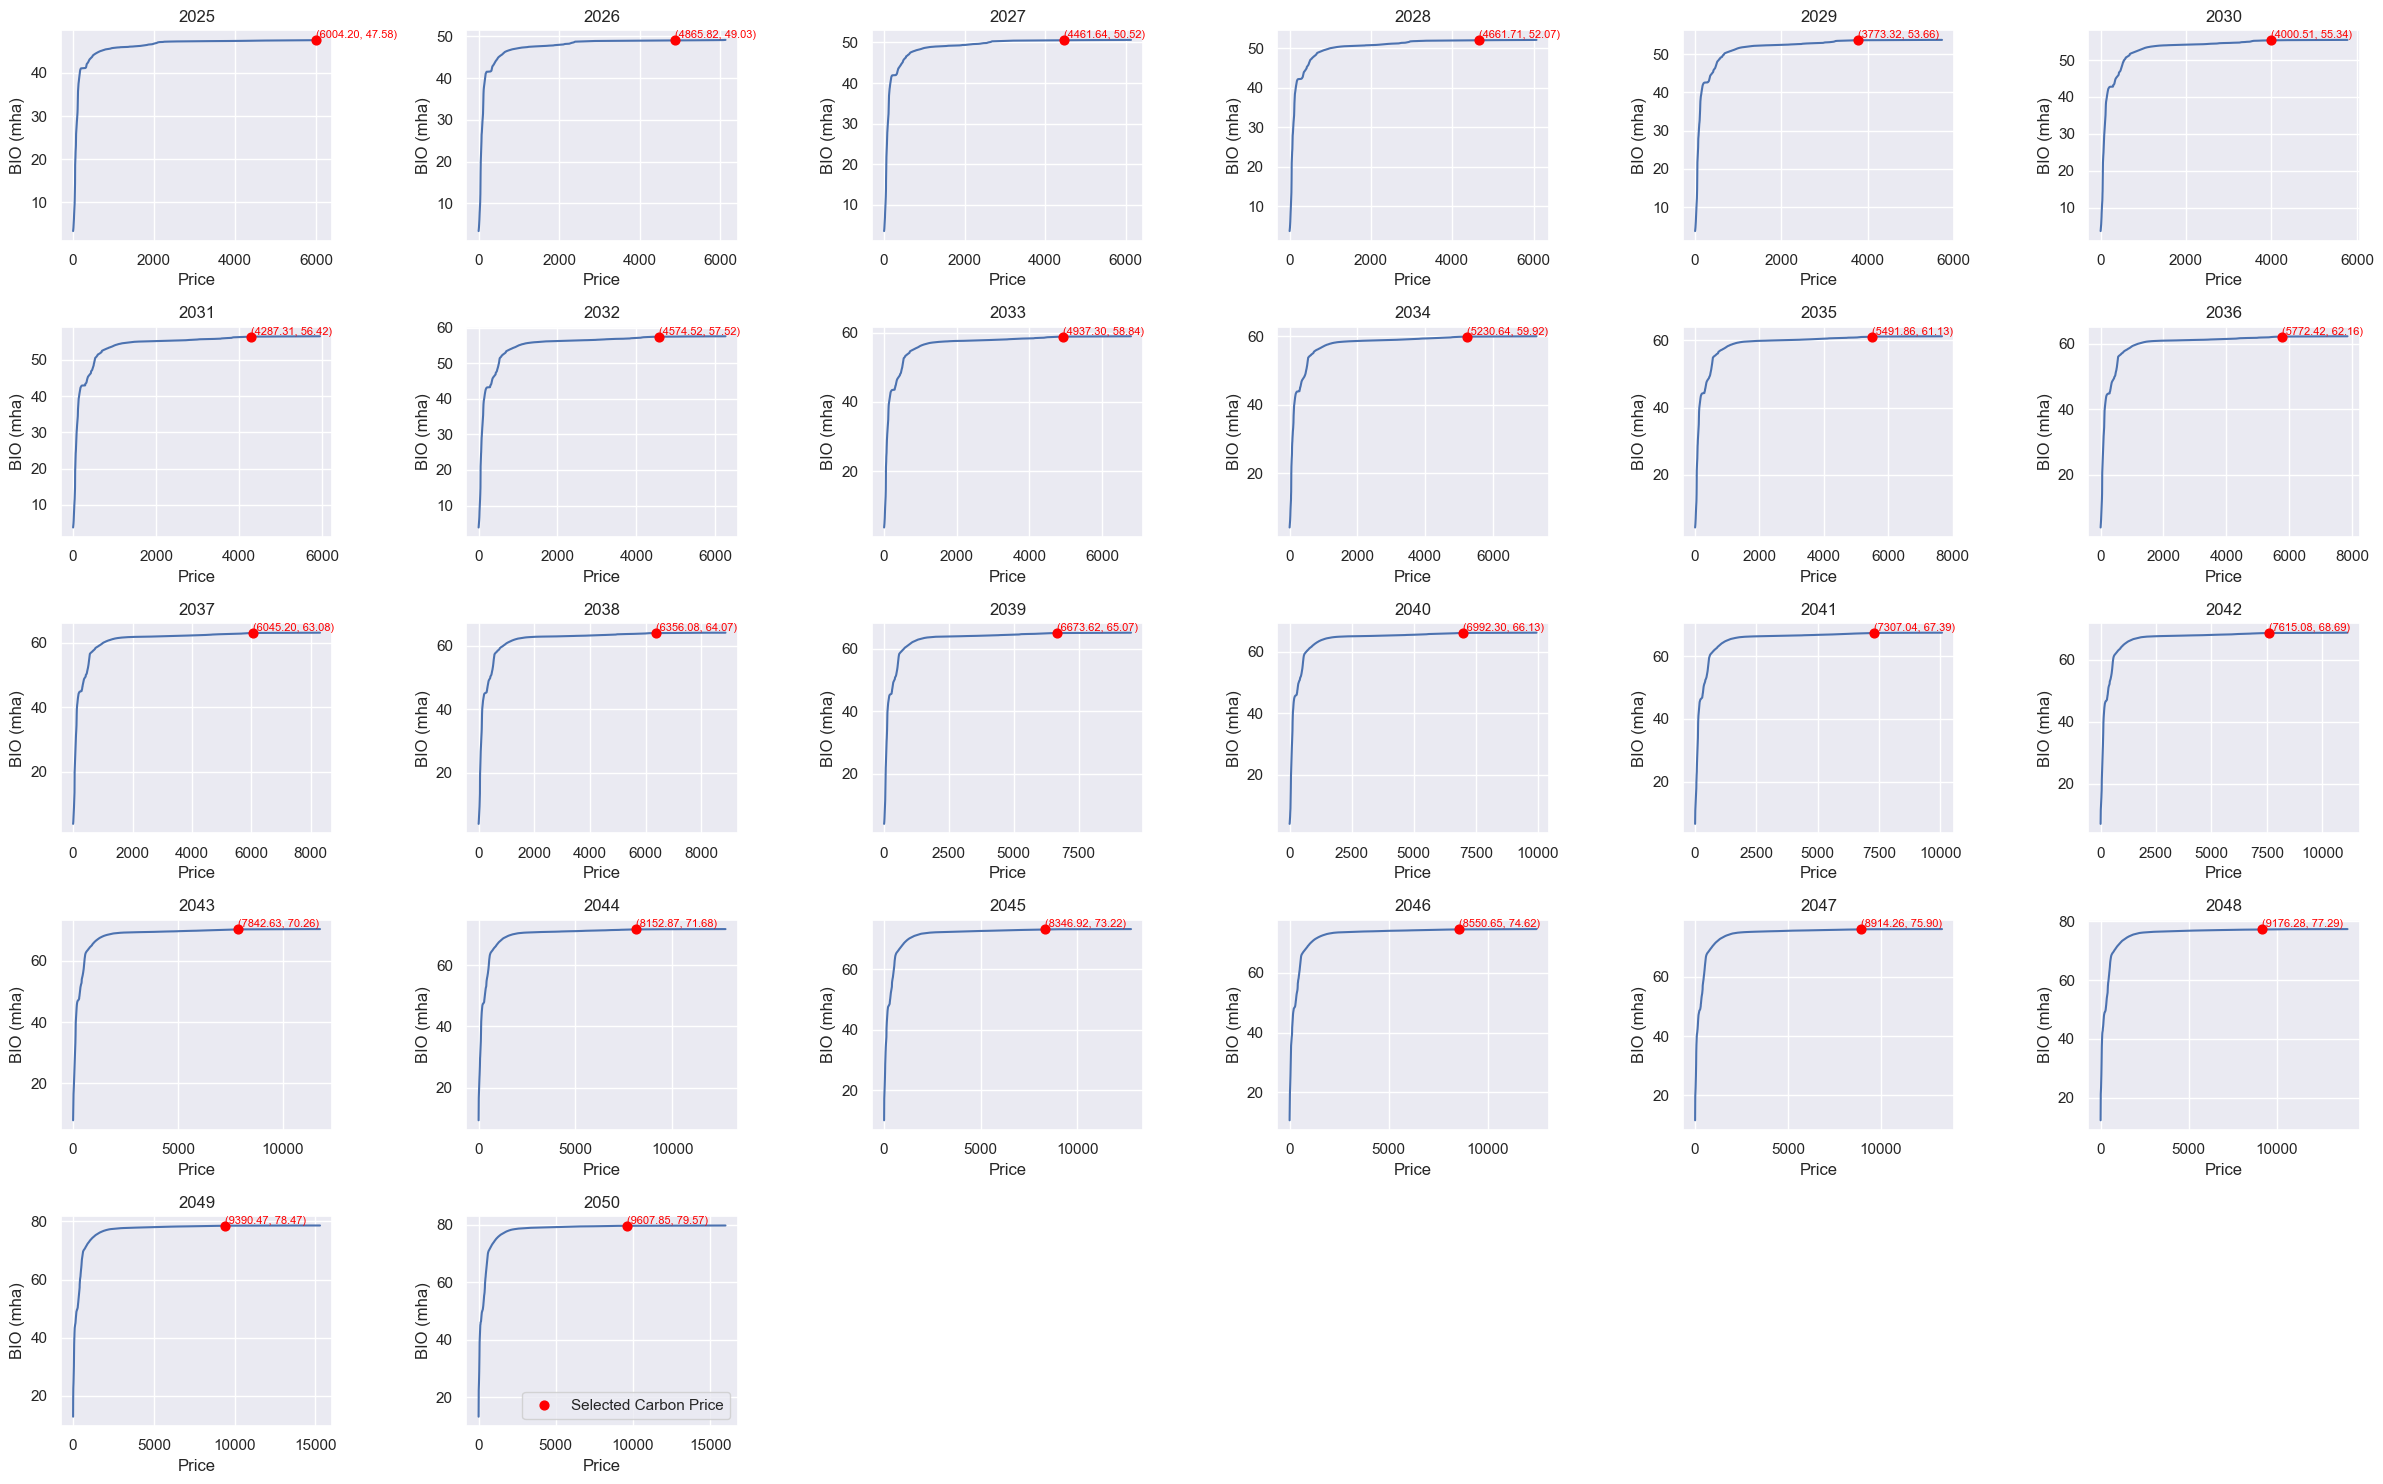

C:\Users\s222552331\AppData\Local\Temp\30\ipykernel_55316\2289049108.py:21: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
C:\Users\s222552331\Anaconda3\envs\xpluto\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.


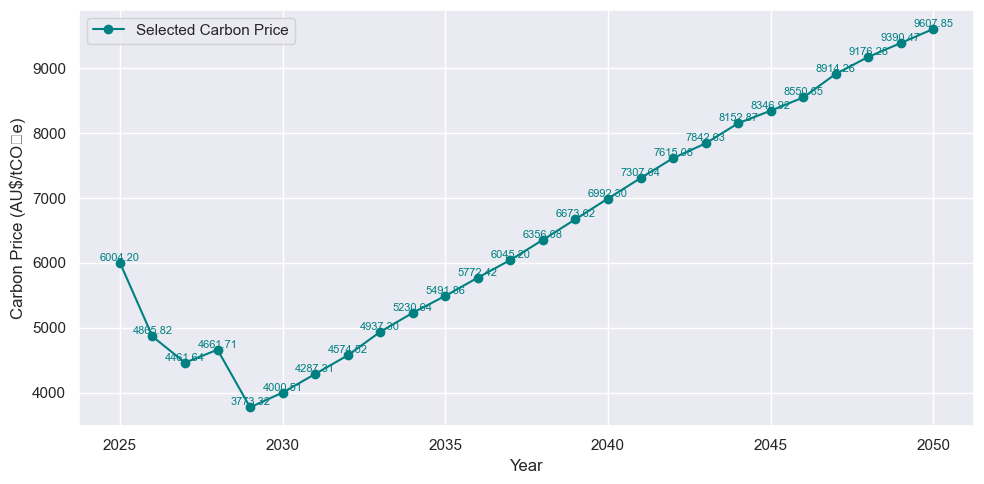

In [248]:
plot_data = {}
prev_x = None
for year in range(2025, 2051):
    x, y, elbow = process_cuve_data(year, 'bio_price','bio', gap=0.1)
    plot_data[year] = {'x': x, 'y': y, 'point': elbow}
    print(year, elbow[0], elbow[1])
    # prev_x = elbow[0]  # 下一年只考虑这个点以后的x

# 每列 6 张图
batch_plot_efficiency(plot_data, 'BIO (mha)', per_col=6)
plot_price(plot_data)

2025 193.03656339176493 75.14694988396485
2026 186.04145854588634 79.43920531115829
2027 189.38811500196908 81.48671079407987
2028 197.75999063867334 83.59419053699153
2029 189.48139822840872 84.30108080634984
2030 177.27487912227036 85.0584952065742
2031 179.07963494119963 91.61886359837747
2032 179.721544334048 99.84815829922668
2033 176.76438418807794 109.83053567420652
2034 169.90144480105482 128.5365387684132
2035 171.10729249781056 141.1879804872425
2036 187.73933280744117 153.9208205071344
2037 203.55624073872238 168.0243861256469
2038 217.96740164222908 183.37168735140955
2039 230.11871267211166 197.38499305195035
2040 248.32872398314723 211.5107418473289
2041 262.518420503441 225.77194662719558
2042 278.2549751555933 240.06127250526018
2043 336.3033285797085 254.4293433333211
2044 315.022698169702 268.6415818312875
2045 367.2505798425112 282.9245541882864
2046 414.5731059697093 297.28327400416606
2047 437.8520470104411 311.4978561390263
2048 436.21663827983485 325.867540822991

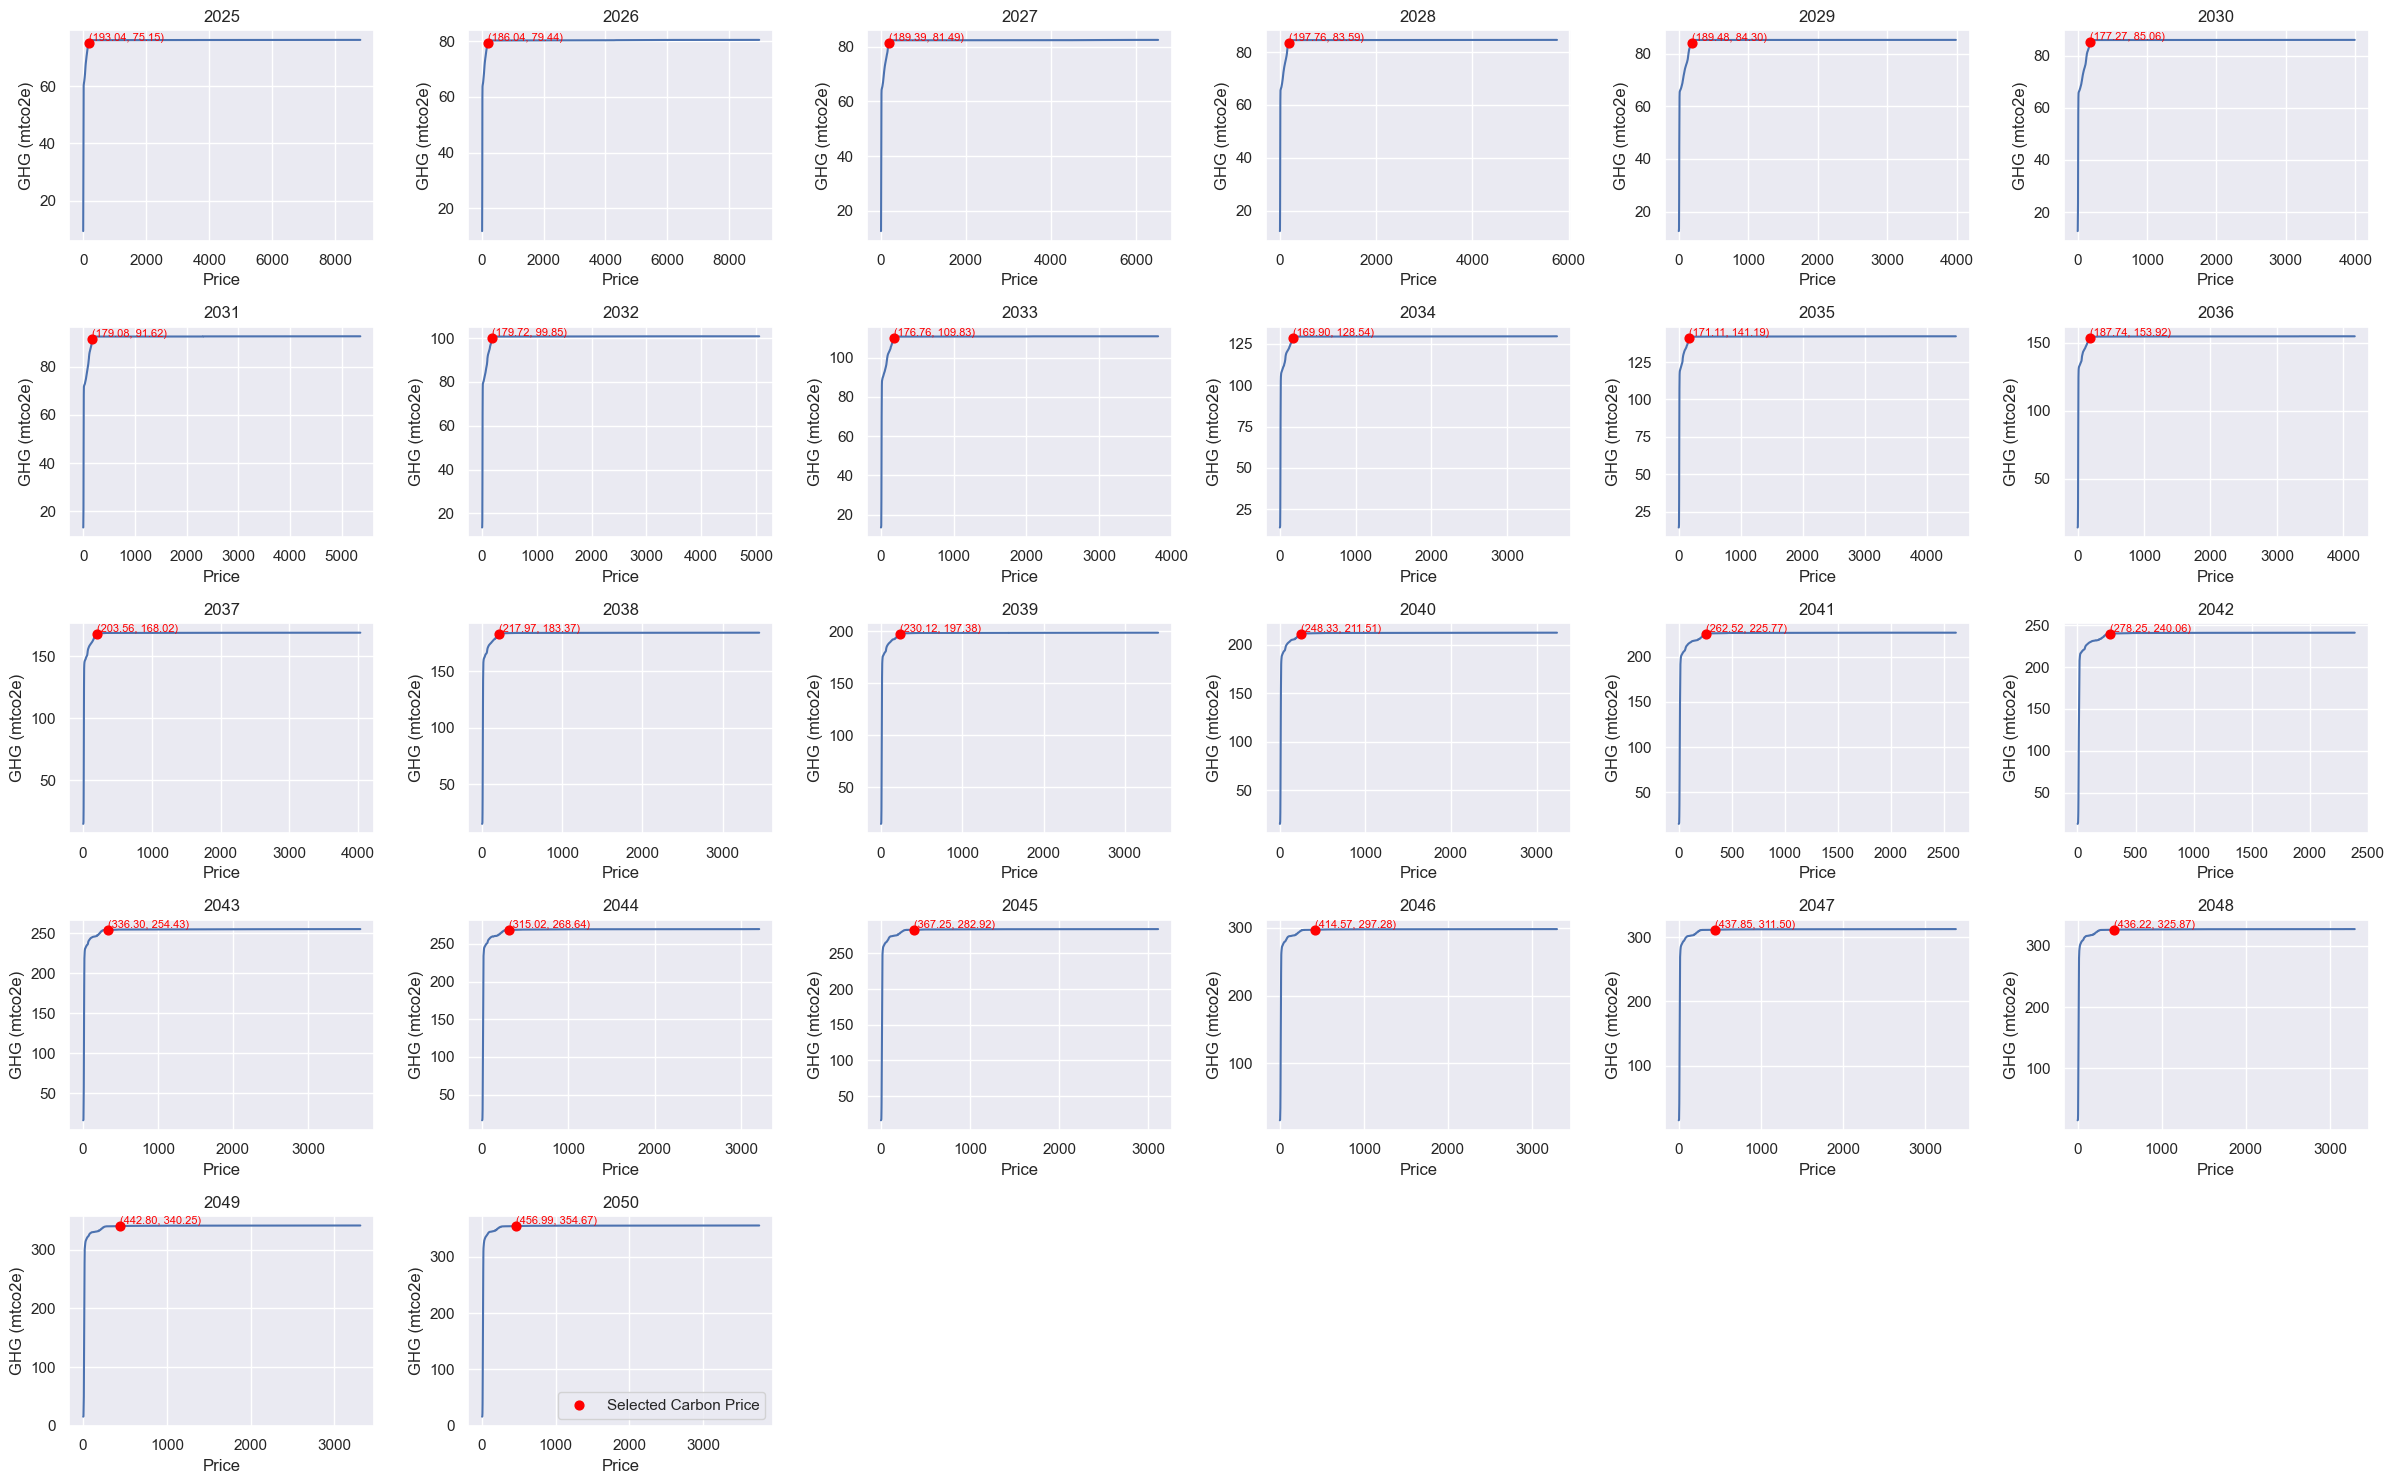

C:\Users\s222552331\AppData\Local\Temp\30\ipykernel_55316\2289049108.py:21: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
C:\Users\s222552331\Anaconda3\envs\xpluto\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.


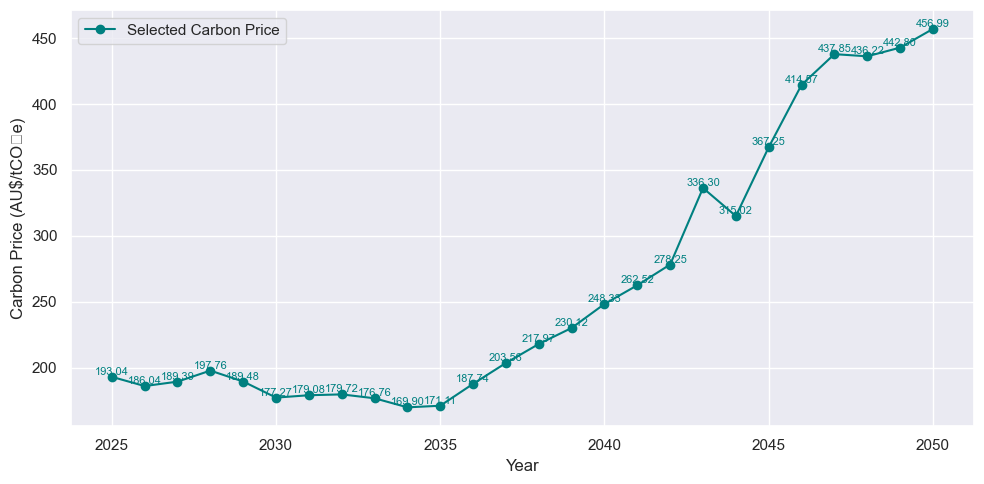

In [245]:
plot_data = {}
prev_x = None
for year in range(2025, 2051):
    x, y, elbow = process_cuve_data(year, 'carbon_price','ghg', gap=1)
    plot_data[year] = {'x': x, 'y': y, 'point': elbow}
    print(year, elbow[0],elbow[1])
    # prev_x = elbow[0]  # 下一年只考虑这个点以后的x

# 每列 6 张图
batch_plot_efficiency(plot_data, 'GHG (mtco2e)', per_col=6)
plot_price(plot_data)